<a href="https://colab.research.google.com/github/project-ida/nuclear-reactions/blob/20241119-gamow/fusion-rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/nuclear-reactions/blob/20241119-gamow/fusion-rates.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Fusion rates

In this notebook, we'll calculate nuclear fusion rates for using the [Gamow model](https://web.archive.org/web/20200504014928/http://web.ihep.su/dbserv/compas/src/gamow28/eng.pdf). We'll focus our attention the spontaneous fusion of two deuterons in a $\rm D_2$ molecule.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import pandas as pd
from scipy.integrate import simps, trapz
pd.set_option('display.max_rows', 300)  # or None to display an unlimited number of rows

/Users/matt/anaconda3/envs/anaconda/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Constants
hbar = 1.054571817e-34
amu = 1.66053906892e-27 # 1 amu in kg
a0 = 0.529177210903e-10 # bohr radius in m
Ry_to_eV = 13.605693122990 # 1 Rydberg in eV
J_to_eV = 1/1.602176634e-19 # 1 Joule in eV
eV_to_J = 1.602176634e-19 # 1 eV in Joules

In [3]:
# Deuterium information
deuteron_mass = 2.013553212745 * amu
muDD = ((deuteron_mass*deuteron_mass) / (deuteron_mass+deuteron_mass)) # reduced mass of D2 in kg

## Nuclear fusion

Fusion can be described as a two step process:
1. A quantum tunneling event through a potential barrier, with the barrier defined by the interatomic potential between two nuclei.
2. A relaxation or decay of the highly clustered nuclei into some ground state or decay products (with the concomitant release of energy)

Step 2 is concerned with nuclear physics and proceeds at a rate $\gamma$ that's determined from experiment and is typically extremely fast (~$10^{20} s^{-1}$).

Step 1 is concerned with solving the [reduced radial Schrödinger equation](https://physics.weber.edu/schroeder/quantum/RadialEquation.pdf) for $u(r)$ that describes the distance, $r$, between the two nuclei:

$$-\frac{\hbar^2}{2\mu} \frac{d^2 u(r)}{dr^2} +  V_{\rm eff}(r) u(r) = E u(r)$$

with $$V_{\rm eff}(r) = V(r) + \frac{L(L+1)\hbar^2}{2\mu r^2}$$

where $\mu$ is the reduced mass of the nuclei, $V(r)$ is the interatomic potential and $\frac{L(L+1)\hbar^2}{2\mu r^2}$ is the centripetal potential associated with the orbital angular momentum, $L$, of the nuclei with respect to one another. 

Note that the total wavefunction $\psi(r, \theta, \phi) = R(r) Y_l^m(\theta, \phi)$ and the "reduced radial wavefunction" is $u(r) = rR(r)$.

A tunneling probability $T$ can then be calculated based on integrating $|u(r)|^2$ over the classically forbidden region where the two nuclei don't have sufficient energy to overcome the barrier.

The fusion rate can then be simply written as 

$$\Gamma = T\gamma$$



## The Gamow model

Instead of solving the Schrödinger exactly, we can apply the [WKB approximation](https://en.wikipedia.org/wiki/Quantum_tunnelling#WKB_approximation) to obtain a simpler approximate solution. This was the approach taken by [Gamow](https://web.archive.org/web/20200504014928/http://web.ihep.su/dbserv/compas/src/gamow28/eng.pdf) in 1928 which yields an analytical expression for the tunneling probability:

$$T = e^{-2 G} $$

with the Gamow factor $G$ is given by:

$$G = \int_{r_1}^{r_2} \sqrt{\frac{2\mu}{\hbar^2}\left[V_{\rm eff}(r) - E\right]} \, dr$$

where the integration is inside the classically forbidden region and so $r_1$ and $r_2$ are the classical turning points for the potential barrier.

The Gamow model is designed for 1D problems. However, it can be adjusted to work for realistic 3D problems by augmenting the fusion rate with a "correction factor" $C$. Specifically:

$$\Gamma = CT\gamma$$

where $C$ depends on the specific fusion problem being considered.

## Potentials

The effective potential includes the interatomic potential and the centripetal potential:

$$V_{\rm eff}(r) = V(r) + \frac{L(L+1)\hbar^2}{2\mu r^2}$$


For a $\rm D_2$ molecule, the interatomic potential $V(r)$ consists of 2 parts - the nuclear and molecular potentials:

$$V(r) = V_{\rm nuc}^{S,L}(r) + V_{\rm mol}(r)$$



### Nuclear potential

We use the Woods-Saxon nuclear potential (in MeV):

$$V_{\rm nuc}^{S,L}(r) ~=~ {V_0 \over 1 + e^{(r - r_S) / a_S}}$$


In [4]:
# The nuclear Woods-Saxon nuclear potential
def V_nuc(r, V0, r_S, a_S):
    return V0 / (1 + np.exp((r - r_S) / a_S))

The parameters depend on the total spin ($S$) and orbital ($L$) angular momenta of the nuclei as seen below and can be found in [Tomusiak et.al](http://dx.doi.org/10.1103/physrevc.52.1963).

| State | $V_0$ (MeV) | $r_s$ (fm) | $a_s$ (fm) |
|-------|-------------|------------|------------|
| $^1S$ | -74.0       | 1.70       | 0.90       |
| $^5S$ | -15.5       | 3.59       | 0.81       |
| $^3P$ | -13.5       | 5.04       | 0.79       |
| $^5D$ | -15.5       | 3.59       | 0.81       |

In [5]:
# Parameters for nuclear potential depend on the state
states = [
    {"state": r"$^1S$: L=0, S=0", "L":0, "S":0, "V0": -74.0, "r_S": 1.70, "a_S": 0.90},
    {"state": r"$^5S$: L=0, S=2", "L":0, "S":2, "V0": -15.5, "r_S": 3.59, "a_S": 0.81},
    {"state": r"$^3P$: L=1, S=1", "L":1, "S":1, "V0": -13.5, "r_S": 5.04, "a_S": 0.79},
    {"state": r"$^5D$: L=2, S=2", "L":2, "S":2, "V0": -15.5, "r_S": 3.59, "a_S": 0.81},
]

We can then see that the attractive nuclear potentials become negligible within about 10 fm.

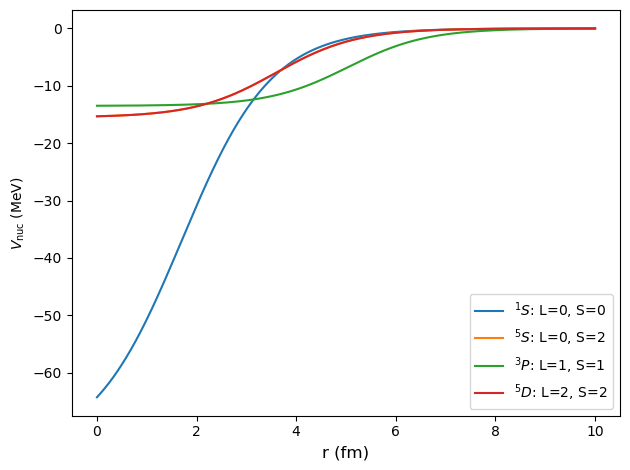

In [6]:
# Generate r values (distance in fm)
r_fm = np.linspace(0, 10, 500)

# Plot the potential for each state
plt.figure()
for state in states:
    V0, r_S, a_S = state["V0"], state["r_S"], state["a_S"]
    plt.plot(r_fm, V_nuc(r_fm, V0, r_S, a_S), label=state["state"])

# Customise the plot
plt.xlabel("r (fm)", fontsize=12)
plt.ylabel("$V_{\\rm nuc}$ (MeV)")
plt.legend()
plt.tight_layout()
# plt.savefig("nuc-potential-D2.png", dpi=600)
plt.show()

### Molecular potential

A $\rm D_2$ molecule exists because of a balance between the electrostatic repulsion between the nuclei and an attraction  between nuclei and the electron cloud. This balance results in a 74 pm equilibrium distance between the deuterons in a gas.

There are several options for representing the molecular potential. For example, the [Morse Potential](https://en.wikipedia.org/wiki/Morse_potential) is popular. For a more accurate potential, however, we will draw upon the work of [Kolos 1986](http://dx.doi.org/10.1063/1.1669836). We parameterised the numerical Kolos potential as:

$$V_{mol}(r) = \frac{2}{r}(1 - b_1r - b_2r^2) e^{-\alpha r^s}$$

with $r$ in units of the Bohr radius ($a_0$), $V_{mol}$ is in Rydbergs and with
- $\alpha = 0.6255121237003474$
- $b_1 = 1.4752572117720800$
- $b_2 = -0.2369829512108492$
- $s = 1.0659864120418940$

We'll make a function that aligns with the nuclear potential in the sense that it takes $r$ in fm and returned potential in MeV.

In [7]:
alpha = 0.6255121237003474
b1 = 1.4752572117720800
b2 = -0.2369829512108492
s = 1.0659864120418940

# Kolos potential in MeV with r in fm
def V_mol(r_fm):
    r = r_fm*1e-15/a0 # fm to a0
    return (2 / r) * (1 - b1 * r - b2 * r**2) * np.exp(-alpha * r**s) * Ry_to_eV / 1e6

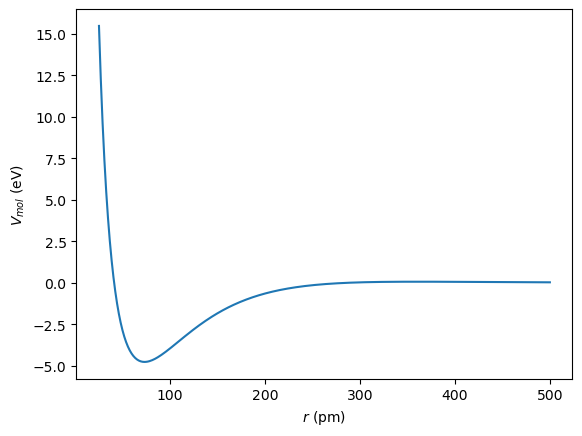

In [8]:

# Range for r in pm for plotting and fm for the potential functions
r_pm = np.linspace(25, 500, 500)
r_fm = r_pm*1000

# Calculate V_mol in MeV
V_values = V_mol(r_fm)

# Plot
plt.figure()
plt.plot(r_pm, V_values*1e6, label=r"$V_{mol}(r)$")
plt.xlabel(r"$r$ (pm)")
plt.ylabel(r"$V_{mol}$ (eV)")
# plt.savefig("mol-potential-D2.png", dpi=600)
plt.show()

### Centripetal potential

The centripetal potential is a pseudo-potential that results from casting the Schrödinger equation into a spherical coordinate system. Its repulsive nature prevents systems of attracting bodies that orbit around each other from collapsing in on themselves. It's given by:

$$V_{\rm cent} = \frac{L(L+1)\hbar^2}{2\mu r^2}$$

where everything is in SI units.

To align with the other potentials, we'll need to create a function that can take $r$ in fm and returns the potential in MeV.

In [9]:
# Centripetal potential in MeV with r in fm
def V_cent(r_fm, L):
    r = r_fm*1e-15
    return (hbar**2 / (2 * muDD)) * (L * (L + 1)) / (r**2) * J_to_eV / 1e6

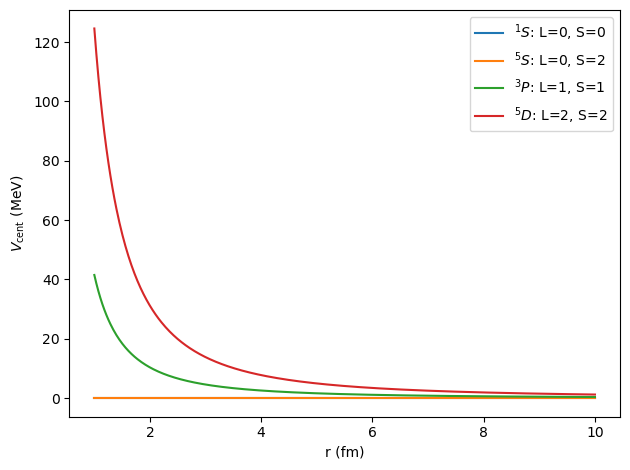

In [10]:
# Generate r values (distance in fm)
r_fm = np.linspace(1, 10, 500)

# Plot the potential for each state
plt.figure()
for state in states:
    L = state["L"]
    plt.plot(r_fm, V_cent(r_fm, L), label=state["state"])


# Customise the plot
plt.xlabel("r (fm)")
plt.ylabel("$V_{\\rm cent}$ (MeV)")
plt.legend()
plt.tight_layout()
# plt.savefig("cent-potential-D2.png", dpi=600)
plt.show()

### Total effective potential

Taken all together, we can see both the coulomb barrier and the presence of the attractive nuclear potential on the other side of the barrier.

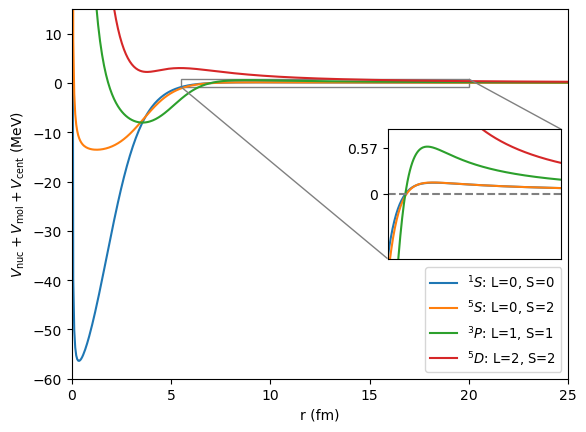

In [11]:
fig, ax = plt.subplots()

# Generate r values (distance in fm)
r_fm = np.linspace(0.01, 25, 500)

# Add inset with a zoomed-in section
ax_inset = inset_axes(ax, width="35%", height="35%", loc='center right')

# Mark the zoomed-in area on the main plot
mark_inset(ax, ax_inset, loc1=3, loc2=1, fc="none", ec="0.5")

# Calculate the total effective potential and plot it on both the main and inset axes
for state in states:
    V0, r_S, a_S, L = state["V0"], state["r_S"], state["a_S"], state["L"]
    V_eff = V_nuc(r_fm, V0, r_S, a_S) + V_cent(r_fm, L) + V_mol(r_fm)
    ax.plot(r_fm, V_eff, label=state["state"])
    ax_inset.plot(r_fm, V_eff, label=state["state"])


# Customise the main plot
ax.set_xlabel("r (fm)")
ax.set_ylabel("$V_{\\rm nuc} + V_{\\rm mol} + V_{\\rm cent}$ (MeV)")
ax.legend(loc="lower right", fontsize=9.5)
ax.set_ylim(-60,15)
ax.set_xlim(0,25)

# Customise the inset plot
x1, x2, y1, y2 = 5.5, 20, -0.8, 0.8  # specify the limits for the inset
ax_inset.axhline(0, color='gray', linestyle='dashed')
ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)
ax_inset.set_yticks([0,0.57])
ax_inset.set_xticks([])
ax_inset.set_yticklabels(['0','0.57'])

# plt.savefig("total-potential-D2.png", dpi=600)
plt.show()


## Calculating the tunneling probability $T$

We first need to define a radial grid that has high resolution near the nucleus and lower resolution at greater distance. We do this because the potential changes a lot when we get closer to the nucleus and so when we're doing the integration for calculating the Gamow factor then we'll incur a lot of error if we don't do this.

In [12]:
# Remember r is in fm
Nr = 30000
rmin = 0.03
rmax = 500000 # this is 500pm
r_fm = np.geomspace(rmin, rmax, Nr) # this creates a logarithmic spacing in the r points

To get a sense of the spacing between the r points, let's visualise a subset of the points.

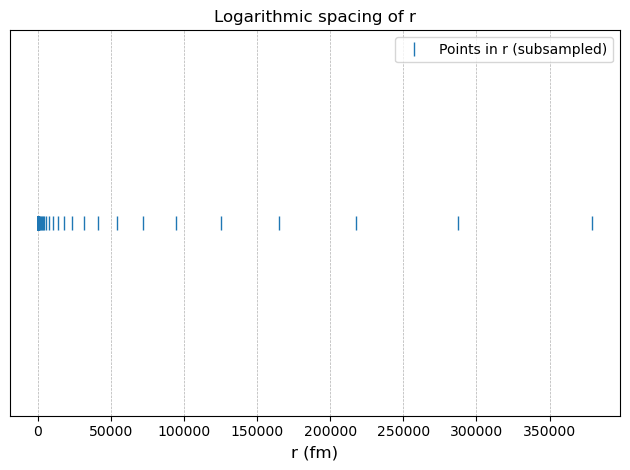

In [13]:
plt.figure()
plt.plot(r_fm[::500], np.zeros_like(r_fm[::500]), '|', markersize=10, label='Points in r (subsampled)')
plt.title("Logarithmic spacing of r")
plt.xlabel("r (fm)", fontsize=12)
plt.yticks([])  # Remove y-axis ticks for clarity
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Now, we will define a function to do the integration that's required to calculate the Gamow factor:

$$G = \int_{r_1}^{r_2} \sqrt{\frac{2\mu}{\hbar^2}\left[V_{\rm eff}(r) - E\right]} \, dr$$

Conceptually, we'll imagine that we can place the deuterons at a specific starting separation $r_{\rm start}$. This starting separation will imbue the deuterons with an energy $E$ that matches the effective potential at that separation. In other words, $E = V_{\rm eff}$, the deuterons are stationary and the they start off at one of the classical turning points $r_{\rm start} = r_{2}$. We then have to integrate down to $r_1$ by finding the other turning point $r_1$ where $E = V_{\rm eff} $.

In [14]:
def calculate_G(r, V, r_start):
    
    # Particles are separated by r_start. 
    # The energy, E, that the particles must have to be at r_start is V(r_start)
    r_start_index = np.where(r > r_start)[0][0]
    E = V[r_start_index]

    # The Gamow factor is calculated based on integrating V-E between the classical turning points.
    V_minus_E = V - E
    
    # We don't have to explicitly calculate the turning points. We can instead integrate from
    # r_start down to some small radius within the nuclear potential well, e.g. 5 fm.
    # We can do this by zeroing out the negative values of V-E in that range.

    V_minus_E = np.maximum(V_minus_E, 0) # negative values of V_minus_E are set to 0
    
    # Determine index of r = 5 fm where we'll cut-off the integration from below
    r_5fm_index = np.where(r > 5)[0][0]
    
    # Create the slice of r and V_minus_E in which we'll do the integration
    r_slice = r[r_5fm_index:r_start_index]
    V_minus_E_slice = V_minus_E[r_5fm_index:r_start_index]
    

    # Perform the integration using the trapezoidal rule
    integral = trapz(np.sqrt(V_minus_E_slice), r_slice)

    # Compute the Gamow factor, remembering to convert everything back to SI units
    # fm -> m needs factor 1e-15
    # MeV -> J needs factor np.sqrt(1e6 * eV_to_J) - Remember V-E is under a square root in the integral
    G = np.sqrt((2 * muDD) / (hbar**2)) * integral * 1e-15 * np.sqrt(1e6 * eV_to_J)

    return G

Now, we're ready to calculate the tunneling probabilities for the different $\rm D_2$ states. We just have to choose a starting separation for the deuterons. We'll start with the equilibrium separation in gas, i.e. 74pm.

In [25]:
r_start = 74000
gamow_results = []

for state in states:
    V0, r_S, a_S, L = state["V0"], state["r_S"], state["a_S"], state["L"]
    V_eff = V_nuc(r_fm, V0, r_S, a_S) + V_cent(r_fm, L) + V_mol(r_fm)
    G = calculate_G(r_fm,V_eff,r_start)
    T = np.exp(-2*G)
    gamow_results.append({
        "state": state['state'],
        "$G$": G,
        "$T=e^{-2G}$": T
    })

# Convert the list of dictionaries to a DataFrame
gamow_results = pd.DataFrame(gamow_results)

# Display the DataFrame
gamow_results

/var/folders/pl/qmlshmls1s1dwnxjx6ld2vb80000gn/T/ipykernel_50959/2178570630.py:3: RuntimeWarning: overflow encountered in exp
  return V0 / (1 + np.exp((r - r_S) / a_S))


,state,$G$,$T=e^{-2G}$
0,"$^1S$: L=0, S=0",88.058615,3.260307e-77
1,"$^5S$: L=0, S=2",88.055305,3.281962e-77
2,"$^3P$: L=1, S=1",90.365226,3.234165e-79
3,"$^5D$: L=2, S=2",94.834208,4.246718e-83


In order to calculate the fusion rate $\Gamma$, we now need to come back and look at the correction factor $C$ and the the nuclear relaxation/decay rate $\gamma$ in:

$$\Gamma = CT\gamma$$

## Volume correction factor for $D_2$

In order to apply the Gamow model in 3D, we need to multiply the fusion rate by by a "correction factor". For the $\rm D_2$ fusion problem, this correction factor is the ratio of the nuclear volume to molecular volume  ${v_{nuc} / v_{mol}}$.

The ratio depends slightly on the state of the $\rm D_2$ molecules. To estimate the ratio, we begin by defining the equilibrium bond lengths for different electronic states of a $ \text{D}_2 $ molecule in terms of the Bohr radius ($ a_0 $):

- For the S state: $ R_{0S} = 1.401080 \times a_0 $
- For the P state: $ R_{0P} = R_{0S} + 0.001 \times 10^{-10} \, \text{m} $
- For the D state: $ R_{0D} = R_{0S} + 0.002 \times 10^{-10} \, \text{m} $

Next, we calculate the de Broglie wavelength of the relative motion ($ \Delta R $) using the formula:

$$
\Delta R = a_0 \sqrt{\frac{I_H}{\hbar \omega_{0DD}}} \sqrt{\frac{2 m_e c^2}{M_{D} c^2}}
$$

where $ I_H $ is the ionization potential of hydrogen in eV, $ \hbar \omega_{0DD} $ is the zero-point energy (0.3862729 eV), $ m_e c^2 $ is the electron mass in MeV, and $ M_D c^2 $ is the deuteron mass in MeV.

The molecular volumes ($ v_{mol} $) for the S, P, and D states are computed as follows:

- S: $ v_{mol} = 2 \pi R_{0S} \left(\pi \Delta R^2\right) $
- P: $ v_{mol} = 2 \pi R_{0P} \left(\pi \Delta R^2\right) $
- D: $ v_{mol} = 2 \pi R_{0D} \left(\pi \Delta R^2\right) $

The nuclear volume ($ v_{nuc} $) of the deuterium nucleus is calculated assuming a spherical shape with a radius of 5 fm:

$$
v_{nuc} = \frac{4}{3} \pi \left(5 \times 10^{-15} \, \text{m}\right)^3
$$

Finally, the volume ratios of the nuclear volume to the molecular volume for the S, P, and D states are calculated as:

- S: $ \frac{v_{nuc}}{v_{mol}} = 6.66 \times 10^{-12} $
- P: $ \frac{v_{nuc}}{v_{mol}} = 6.65 \times 10^{-12} $
- D: $ \frac{v_{nuc}}{v_{mol}} = 6.64 \times 10^{-12} $

In [26]:
gamow_results["$v_{nuc}/v_{mol}$"] = [6.66e-12, 6.66e-12, 6.65e-12, 6.64e-12]
gamow_results

,state,$G$,$T=e^{-2G}$,$v_{nuc}/v_{mol}$
0,"$^1S$: L=0, S=0",88.058615,3.260307e-77,6.660000e-12
1,"$^5S$: L=0, S=2",88.055305,3.281962e-77,6.660000e-12
2,"$^3P$: L=1, S=1",90.365226,3.234165e-79,6.650000e-12
3,"$^5D$: L=2, S=2",94.834208,4.246718e-83,6.640000e-12


## Nuclear relaxation/decay for $\rm D_2$ fusion

When the deuterons tunnel through the Coulomb barrier, for a very brief moment, they form a highly clustered state that can be recognised as an excited state of $\rm ^4He$ (often denoted $\rm ^4He^*$). There are several excited states and they decay via different "channels". For example:
- Relaxation into the ground state $\rm ^4He$ with the emission of a gamma ray
- Decay into a proton and triton
- Decay into a neutron and $\rm ^3He$

Different $\rm D_2$ states tunnel to different $\rm ^4He^*$ states which have unique decay rates $\gamma$. The rates can be found in Table 3.0.1 (page 19) of [Tilley et.al](https://www.sciencedirect.com/science/article/abs/pii/037594749290635W).

**For the $^5S$ state of $\rm D_2$**:

We must refer to the $\rm ^5S$ $J^\pi=2^+$ state of $\rm ^4He^*$ at 27.42 MeV, whose line width is:

$$
\hbar \gamma_{^5S} ~=~ 0.25 + 0.23~\text{MeV} ~=~ 0.48~ \text{MeV}
$$


and whose associated decay rate and lifetime is:

$$
\gamma_{^5S} ~=~ {0.48 ~ {\rm MeV} \over \hbar} ~=~ 7.3 \times 10^{20}~{\rm s}^{-1}
$$
$$
\tau_{^5S} ~=~ {\hbar \over 0.48 ~ {\rm MeV} } ~=~ 1.4 \times 10^{-21} ~{\rm sec} 
$$

We don't have data for the $^1S$ state, so we'll use the $^5S$ result.

**For the $^3P$ state of $\rm D_2$**:

We must refer to the $\rm ^3P$ $J^\pi=1^-$ state of $\rm ^4He^*$ at 28.37 MeV, whose line width is:

$$
\hbar \gamma_{^3P} ~=~ 0.07 + 0.08~\text{MeV} ~=~ 0.15~ \text{MeV}
$$


and whose associated decay rate and lifetime is:

$$
\gamma_{^3P} ~=~ {0.15 ~ {\rm MeV} \over \hbar} ~=~ 2.3 \times 10^{20}~{\rm s}^{-1}
$$
$$
\tau_{^3P} ~=~ {\hbar \over 0.15 ~ {\rm MeV} } ~=~ 4.4 \times 10^{-21} ~{\rm sec} 
$$

**For the $^5D$ state of $\rm D_2$**:

We must refer to the $\rm ^5D$ $J^\pi=2^+$ state of $\rm ^4He^*$ at 29.89 MeV, whose line width is:

$$
\hbar \gamma_{^5D} ~=~ 0.04 + 0.04~\text{MeV} ~=~ 0.08~ \text{MeV}
$$


and whose associated decay rate and lifetime is:

$$
\gamma_{^5D} ~=~ {0.08 ~ {\rm MeV} \over \hbar} ~=~ 1.2 \times 10^{20}~{\rm s}^{-1}
$$
$$
\tau_{^5D} ~=~ {\hbar \over 0.08 ~ {\rm MeV} } ~=~ 8.2 \times 10^{-21} ~{\rm sec} 
$$


In [27]:
gamow_results["$\gamma$"] = [7.3e20, 7.3e20, 2.3e20, 1.2e20]
gamow_results

,state,$G$,$T=e^{-2G}$,$v_{nuc}/v_{mol}$,$\gamma$
0,"$^1S$: L=0, S=0",88.058615,3.260307e-77,6.660000e-12,7.300000e+20
1,"$^5S$: L=0, S=2",88.055305,3.281962e-77,6.660000e-12,7.300000e+20
2,"$^3P$: L=1, S=1",90.365226,3.234165e-79,6.650000e-12,2.300000e+20
3,"$^5D$: L=2, S=2",94.834208,4.246718e-83,6.640000e-12,1.200000e+20


## Calculating the fusion rates

Now we have everything we need to calculate the fusion rates via

$$\Gamma = \frac{v_{nuc}}{v_{mol}}T\gamma$$

In [28]:
gamow_results["$\Gamma$"] = gamow_results["$v_{nuc}/v_{mol}$"]*gamow_results["$T=e^{-2G}$"]*gamow_results["$\gamma$"]
gamow_results

,state,$G$,$T=e^{-2G}$,$v_{nuc}/v_{mol}$,$\gamma$,$\Gamma$
0,"$^1S$: L=0, S=0",88.058615,3.260307e-77,6.660000e-12,7.300000e+20,1.585096e-67
1,"$^5S$: L=0, S=2",88.055305,3.281962e-77,6.660000e-12,7.300000e+20,1.595625e-67
2,"$^3P$: L=1, S=1",90.365226,3.234165e-79,6.650000e-12,2.300000e+20,4.946656e-70
3,"$^5D$: L=2, S=2",94.834208,4.246718e-83,6.640000e-12,1.200000e+20,3.383785e-74
